**MLP : метод обратного распространения ошибки**

два обрабатывающих слоя, стохастический BP

Евгений Борисов borisov.e@solarl.ru

---

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

/usr/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# # загружаем даные
# c1 = np.loadtxt('data/200_2b/points_1.txt')
# c2 = np.loadtxt('data/200_2b/points_2.txt')

In [3]:
# загружаем даные
c1 = np.vstack([
    np.loadtxt('data/399_4/points_b.txt'),
    np.loadtxt('data/399_4/points_g.txt'),
    np.loadtxt('data/399_4/points_r.txt')
])

c2 = np.loadtxt('data/399_4/points_y.txt')


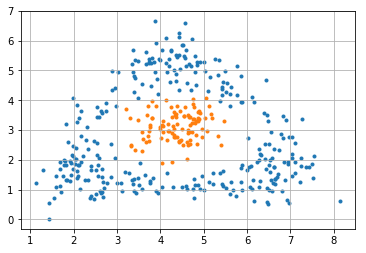

In [4]:
plt.scatter(c1[:,0],c1[:,1],marker='.')
plt.scatter(c2[:,0],c2[:,1],marker='.')
plt.grid()
plt.show()

In [5]:
# собираем вместе
X = np.vstack([c1,c2])
X.shape

(399, 2)

In [6]:
# метки классов
Y = np.array( [-1,1]*c1.shape[0] + 
              [1,-1]*c2.shape[0], 
            ).reshape( c1.shape[0] + c2.shape[0], 2 ) 
Y.shape

(399, 2)

In [7]:
# размер скрытого слоя
s_layer = 10

---

In [8]:
# нормируем данные
scaler = MinMaxScaler([-1.0,1.0])
scaler.fit(X)
X = scaler.transform(X)

X.min(), X.max()

(-1.0, 1.0)

In [9]:
# инициализация генератора псевдослучайных чисел
np.random.seed(seed= int((time.time() % 1)*1e7) )

In [10]:
X, X_test, Y, Y_test = train_test_split( X, Y, test_size=0.5 ) # , random_state=int((time.time() % 1)*1e7) )
# X, X_val, Y, Y_val = train_test_split( X, Y, test_size=0.3) #, random_state=int((time.time() % 1)*1e7) )
X_val, Y_val = X, Y

---

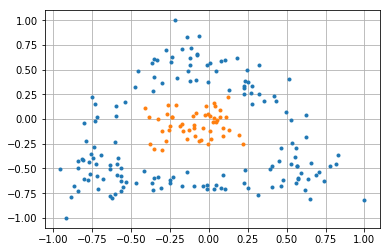

In [11]:
# учебный
r=np.argmax(Y,axis=1).astype(bool)
X1 = X[ r, : ]
X2 = X[ ~r,: ]
fig, ax = plt.subplots()
ax.plot(X1[:,0],X1[:,1],'.')
ax.plot(X2[:,0],X2[:,1],'.')
plt.grid()
plt.show()

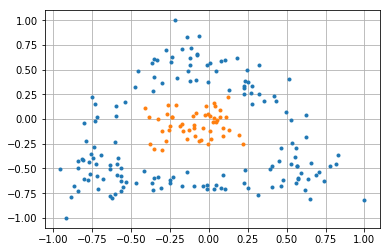

In [12]:
# контрольный
r=np.argmax(Y_val,axis=1).astype(bool)
X1 = X_val[ r, : ]
X2 = X_val[ ~r,: ]
fig, ax = plt.subplots()
ax.plot(X1[:,0],X1[:,1],'.')
ax.plot(X2[:,0],X2[:,1],'.')
plt.grid()
plt.show()

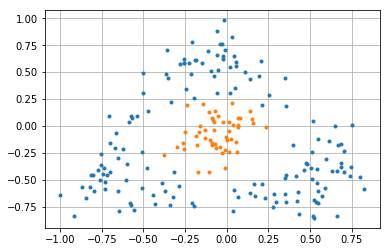

In [13]:
# тестовый
r=np.argmax(Y_test,axis=1).astype(bool)
X1 = X_test[ r, : ]
X2 = X_test[ ~r,: ]
fig, ax = plt.subplots()
ax.plot(X1[:,0],X1[:,1],'.')
ax.plot(X2[:,0],X2[:,1],'.')
plt.grid()
plt.show()

---

In [14]:
# ф-ция активации слоёв
def act(z): return np.tanh(z)

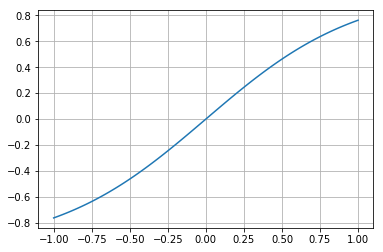

In [15]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act(jj) )
plt.grid()
plt.show()

In [16]:
# производная ф-ции активации слоёв
def act_drv(z): return 1.0/(np.cosh(z)**2)

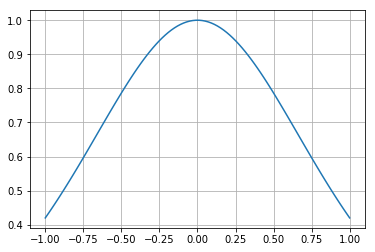

In [17]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act_drv(jj) )
plt.grid()
plt.show()

In [18]:
# инициализация весов и сдвигов
# W0 = ( np.random.rand( X.shape[1], s_layer ) - 0.5 ) * 0.01
W0 = np.random.normal(loc=0.0, scale=0.1, size=[X.shape[1], s_layer])
S0 = np.zeros(s_layer)

#W1 = ( np.random.rand( s_layer,Y.shape[1] ) - 0.5 ) * 0.01
W1 = np.random.normal(loc=0.0, scale=0.1, size=[s_layer,Y.shape[1] ])
S1 = np.zeros(Y.shape[1])

---

In [19]:
# выход
def run(x): 
    return act( act( x.dot(W0) + S0 ).dot(W1) + S1 ) # выход сети


In [20]:
# прямой проход
def forward(x):
    L = [ x.dot(W0) + S0 ] # состояние (не активированное) скрытого слоя
    L.append( act(L[0]).dot(W1) + S1   ) # состояние (не активированное) выходного слоя
    return L


In [21]:
# обратный проход
def backward(L,y):
    O = act(L[1]) # выход сети
    E = [ (O-y)*act_drv(L[1]) ] # ошибка выходного слоя
    E.insert(0, E[0].dot(W1.T)*act_drv(L[0]) ) # ошибка скрытого слоя
    return E


In [22]:
# градиент
def grad(L,E,x):
    GW = [ x.T.dot(E[0]) ] # градиент по весам скрытого слоя
    GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

    O = act(L[0]) # выход скрытого слоя
    GW.append( O.T.dot(E[1]) ) # градиент по весам выходного слоя
    GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

    return GW,GS


In [23]:
# нормируем градиент
def grad_norm(gw,gs):
    mw = np.abs(np.hstack([ gw[0].flatten(), gw[1].flatten(), gs[0], gs[1], ])).max()
        
    if mw != 0.0:
        gw[0] = gw[0]/mw
        gw[1] = gw[1]/mw
        gs[0] = gs[0]/mw
        gs[1] = gs[1]/mw
    
    return gw,gs

In [24]:
def msqe(o,y):
    e = (o-y).flatten() # ошибки примеров
    e = np.asscalar( e.T.dot(e) )*(1.0/y.shape[0])  # средняя квадратичная ошибка
    assert ~np.isnan(e), 'ошибка вычислений'
    return e

In [25]:
# метод градиентного спуска, стохастическая стратегия
a=0.1 # скорость обучения

ex_count = X.shape[0]   # количество примеров

MAX_ITER = 150 # максимальное число циклов обучен

MIN_ERROR = 0.22 # порог минимальной ошибки

# ex_count_div = (1.0/ex_count)
err =[1e7] 

f_stop = False

for i in range(MAX_ITER):
    r_idx = np.random.permutation(ex_count) # случайный порядок примеров

    for j in r_idx:
        
        O = run(X_val) # выход сети
        err.append( msqe(O,Y_val) ) # история значений ф-ции потери
        if err[-1] < MIN_ERROR: # проверяем достижение порога ошибки (ф-ции потери)
            f_stop = True
            break
        
        de = err[-1] - err[-2] # изменение ошибки
        if ( de > 0.0 ):  # если ошибка выросла...
            p=1.0/(1.0+np.exp(-de)) 
            if(np.random.rand() < p): # ...то возврат старого состояния с вероятностью p
                W0,S0,W1,S1 = W0p,S0p,W1p,S1p 
                err = err[:-1]
        # выбираем пример        
        xj=X[j,:].reshape(1,X.shape[1])
        yj=Y[j,:].reshape(1,Y.shape[1])
        
        L=forward(xj) # прямой проход
        E=backward(L,yj) # обратный проход
        GW,GS = grad(L,E,xj) # градиент
        GW,GS = grad_norm(GW,GS) # нормируем градиент

        # сохраняем старые веса
        W0p,S0p,W1p,S1p = W0,S0,W1,S1
        
        # изменяем веса и сдвиги
        W0 = W0 - a*GW[0]
        W1 = W1 - a*GW[1]
        S0 = S0 - a*GS[0]
        S1 = S1 - a*GS[1]
        
    print('epoch:',i+1,'/',MAX_ITER, 'error:',err[-1],'/',MIN_ERROR)
    
    if (f_stop):  break
   

epoch: 1 / 150 error: 1.81046924648054 / 0.22
epoch: 2 / 150 error: 2.0090777996248357 / 0.22
epoch: 3 / 150 error: 2.010050251255915 / 0.22
epoch: 4 / 150 error: 2.0100502512562812 / 0.22
epoch: 5 / 150 error: 2.0100502512562812 / 0.22
epoch: 6 / 150 error: 2.0100502512562812 / 0.22
epoch: 7 / 150 error: 2.0100502512562812 / 0.22
epoch: 8 / 150 error: 2.0100502512562812 / 0.22
epoch: 9 / 150 error: 2.0100502512562812 / 0.22
epoch: 10 / 150 error: 2.0100502512562812 / 0.22
epoch: 11 / 150 error: 2.0100502512562812 / 0.22
epoch: 12 / 150 error: 2.0100502512540257 / 0.22
epoch: 13 / 150 error: 2.0100502512562812 / 0.22
epoch: 14 / 150 error: 2.0100502512562812 / 0.22
epoch: 15 / 150 error: 2.0100502512562812 / 0.22
epoch: 16 / 150 error: 2.0100502512539187 / 0.22
epoch: 17 / 150 error: 2.0100502512562812 / 0.22
epoch: 18 / 150 error: 2.0100502512562812 / 0.22
epoch: 19 / 150 error: 2.0100502512562812 / 0.22
epoch: 20 / 150 error: 2.0100502512562772 / 0.22
epoch: 21 / 150 error: 2.0100502

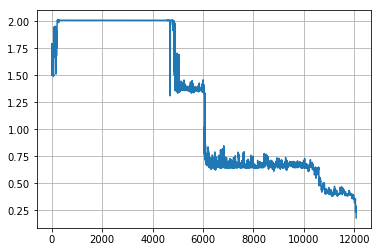

In [26]:
# изменение ошибки обучения
fig, ax = plt.subplots()
ax.plot(err[2:])
plt.grid()
plt.show()

---

0.6868454170508386


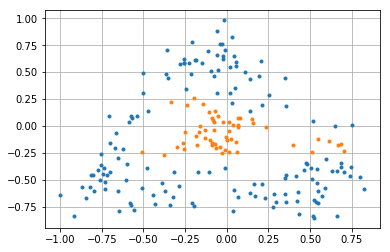

In [28]:
# результат
O = run(X_test)
print(msqe(O,Y_test))
r=np.argmax(O,axis=1).astype(bool)

X1 = X_test[ r, : ]
X2 = X_test[ ~r,: ]

fig, ax = plt.subplots()
ax.plot(X1[:,0],X1[:,1],'.')
ax.plot(X2[:,0],X2[:,1],'.')
plt.grid()
plt.show()